In [53]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train = False,
    download = True,
    transform = ToTensor()
)


In [15]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [35]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 10, 3
img, label = training_data[0]
d1, d2, d3 = img.shape
img_map = torch.zeros(cols, rows, d1, d2, d3)
cnt = np.zeros(cols, dtype=int)
print(cnt.dtype)

while np.sum(cnt) < cols *rows:
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    if cnt[label] >= rows:
        continue
    img_map[label][cnt[label]] = img
    cnt[label] += 1
    print(np.sum(cnt))

int64
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


<Figure size 800x800 with 0 Axes>

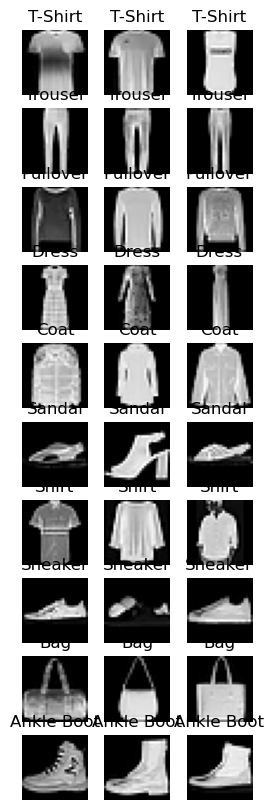

In [39]:
figure = plt.figure(figsize=(rows, cols))
for i in range(cols):
    for j in range(rows):
        figure.add_subplot(cols, rows, i * rows + j + 1)
        plt.title(labels_map[i])
        plt.axis("off")
        plt.imshow(img_map[i][j].squeeze(), cmap=plt.cm.gray)
plt.show()

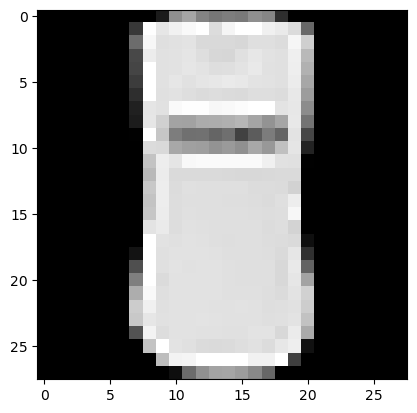

In [40]:
plt.imshow(img_map[0][2].squeeze(), cmap=plt.cm.gray)

In [41]:
import os
from torch import nn
from torchvision import transforms

In [42]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [43]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [44]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
  )
)


In [45]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")
print(logits) #logits는 scores arr

Predicted class: tensor([0], device='cuda:0')
tensor([[ 0.3511,  0.2289,  0.0997, -0.2240, -0.0907,  0.3181, -0.2567, -0.2535,
         -0.2681, -0.0703]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [46]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [47]:
# 손실 함수를 초기화합니다.
loss_fn = nn.CrossEntropyLoss()

In [48]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [59]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # 모델을 학습(train) 모드로 설정합니다 - 배치 정규화(Batch Normalization) 및 드롭아웃(Dropout) 레이어들에 중요합니다.
    # 이 예시에서는 없어도 되지만, 모범 사례를 위해 추가해두었습니다.
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # 예측(prediction)과 손실(loss) 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # 모델을 평가(eval) 모드로 설정합니다 - 배치 정규화(Batch Normalization) 및 드롭아웃(Dropout) 레이어들에 중요합니다.
    # 이 예시에서는 없어도 되지만, 모범 사례를 위해 추가해두었습니다.
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # torch.no_grad()를 사용하여 테스트 시 변화도(gradient)를 계산하지 않도록 합니다.
    # 이는 requires_grad=True로 설정된 텐서들의 불필요한 변화도 연산 및 메모리 사용량 또한 줄여줍니다.
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [60]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [61]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.254680  [   64/60000]
loss: 2.279873  [ 6464/60000]
loss: 2.279868  [12864/60000]
loss: 2.321560  [19264/60000]
loss: 2.225476  [25664/60000]
loss: 2.264220  [32064/60000]
loss: 2.267281  [38464/60000]
loss: 2.234421  [44864/60000]
loss: 2.224272  [51264/60000]
loss: 2.308730  [57664/60000]
Test Error: 
 Accuracy: 19.7%, Avg loss: 2.235966 

Epoch 2
-------------------------------
loss: 2.190758  [   64/60000]
loss: 2.207560  [ 6464/60000]
loss: 2.196795  [12864/60000]
loss: 2.260209  [19264/60000]
loss: 2.137525  [25664/60000]
loss: 2.182031  [32064/60000]
loss: 2.201626  [38464/60000]
loss: 2.155080  [44864/60000]
loss: 2.143563  [51264/60000]
loss: 2.241755  [57664/60000]
Test Error: 
 Accuracy: 28.5%, Avg loss: 2.144389 

Epoch 3
-------------------------------
loss: 2.096225  [   64/60000]
loss: 2.098462  [ 6464/60000]
loss: 2.059793  [12864/60000]
loss: 2.157591  [19264/60000]
loss: 1.994022  [25664/60000]
loss: 2.039857  [32064/600